### Analyse et predictions des prix de l'immobilier (Ames Housing)
Objectifs :
- Analyser les données et tirée le maximum d'informations
- construire un modèle capable de predire ,avec le moins d'erreur possible,le prix des maisons  




I-) Importation des bibliotheques 

In [211]:
## Importation des librairies 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression 
import xgboost as xgb 
import lightgbm as lgb 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


II-) Importation et traitement des données 
- II-1-)importation des donnees 

In [212]:
## Importation des jeus de données 
data_train=pd.read_csv("train.csv")
data_test=pd.read_csv("test.csv")

- II-2-)exploration des données 

In [213]:
## exploration des données 
print("Aperçu des données d'entraînement :")
print("="*150)
print(data_train.head())
print("="*150)
print("Voici les informations sur le jeu de données d'entraînement :")
print(data_train.info())
print("="*150)
print("Statistiques descriptives du jeu de données d'entraînement :")
print(data_train.describe())

Aperçu des données d'entraînement :
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1F

- II-3-) analyse de correlation entre variables 

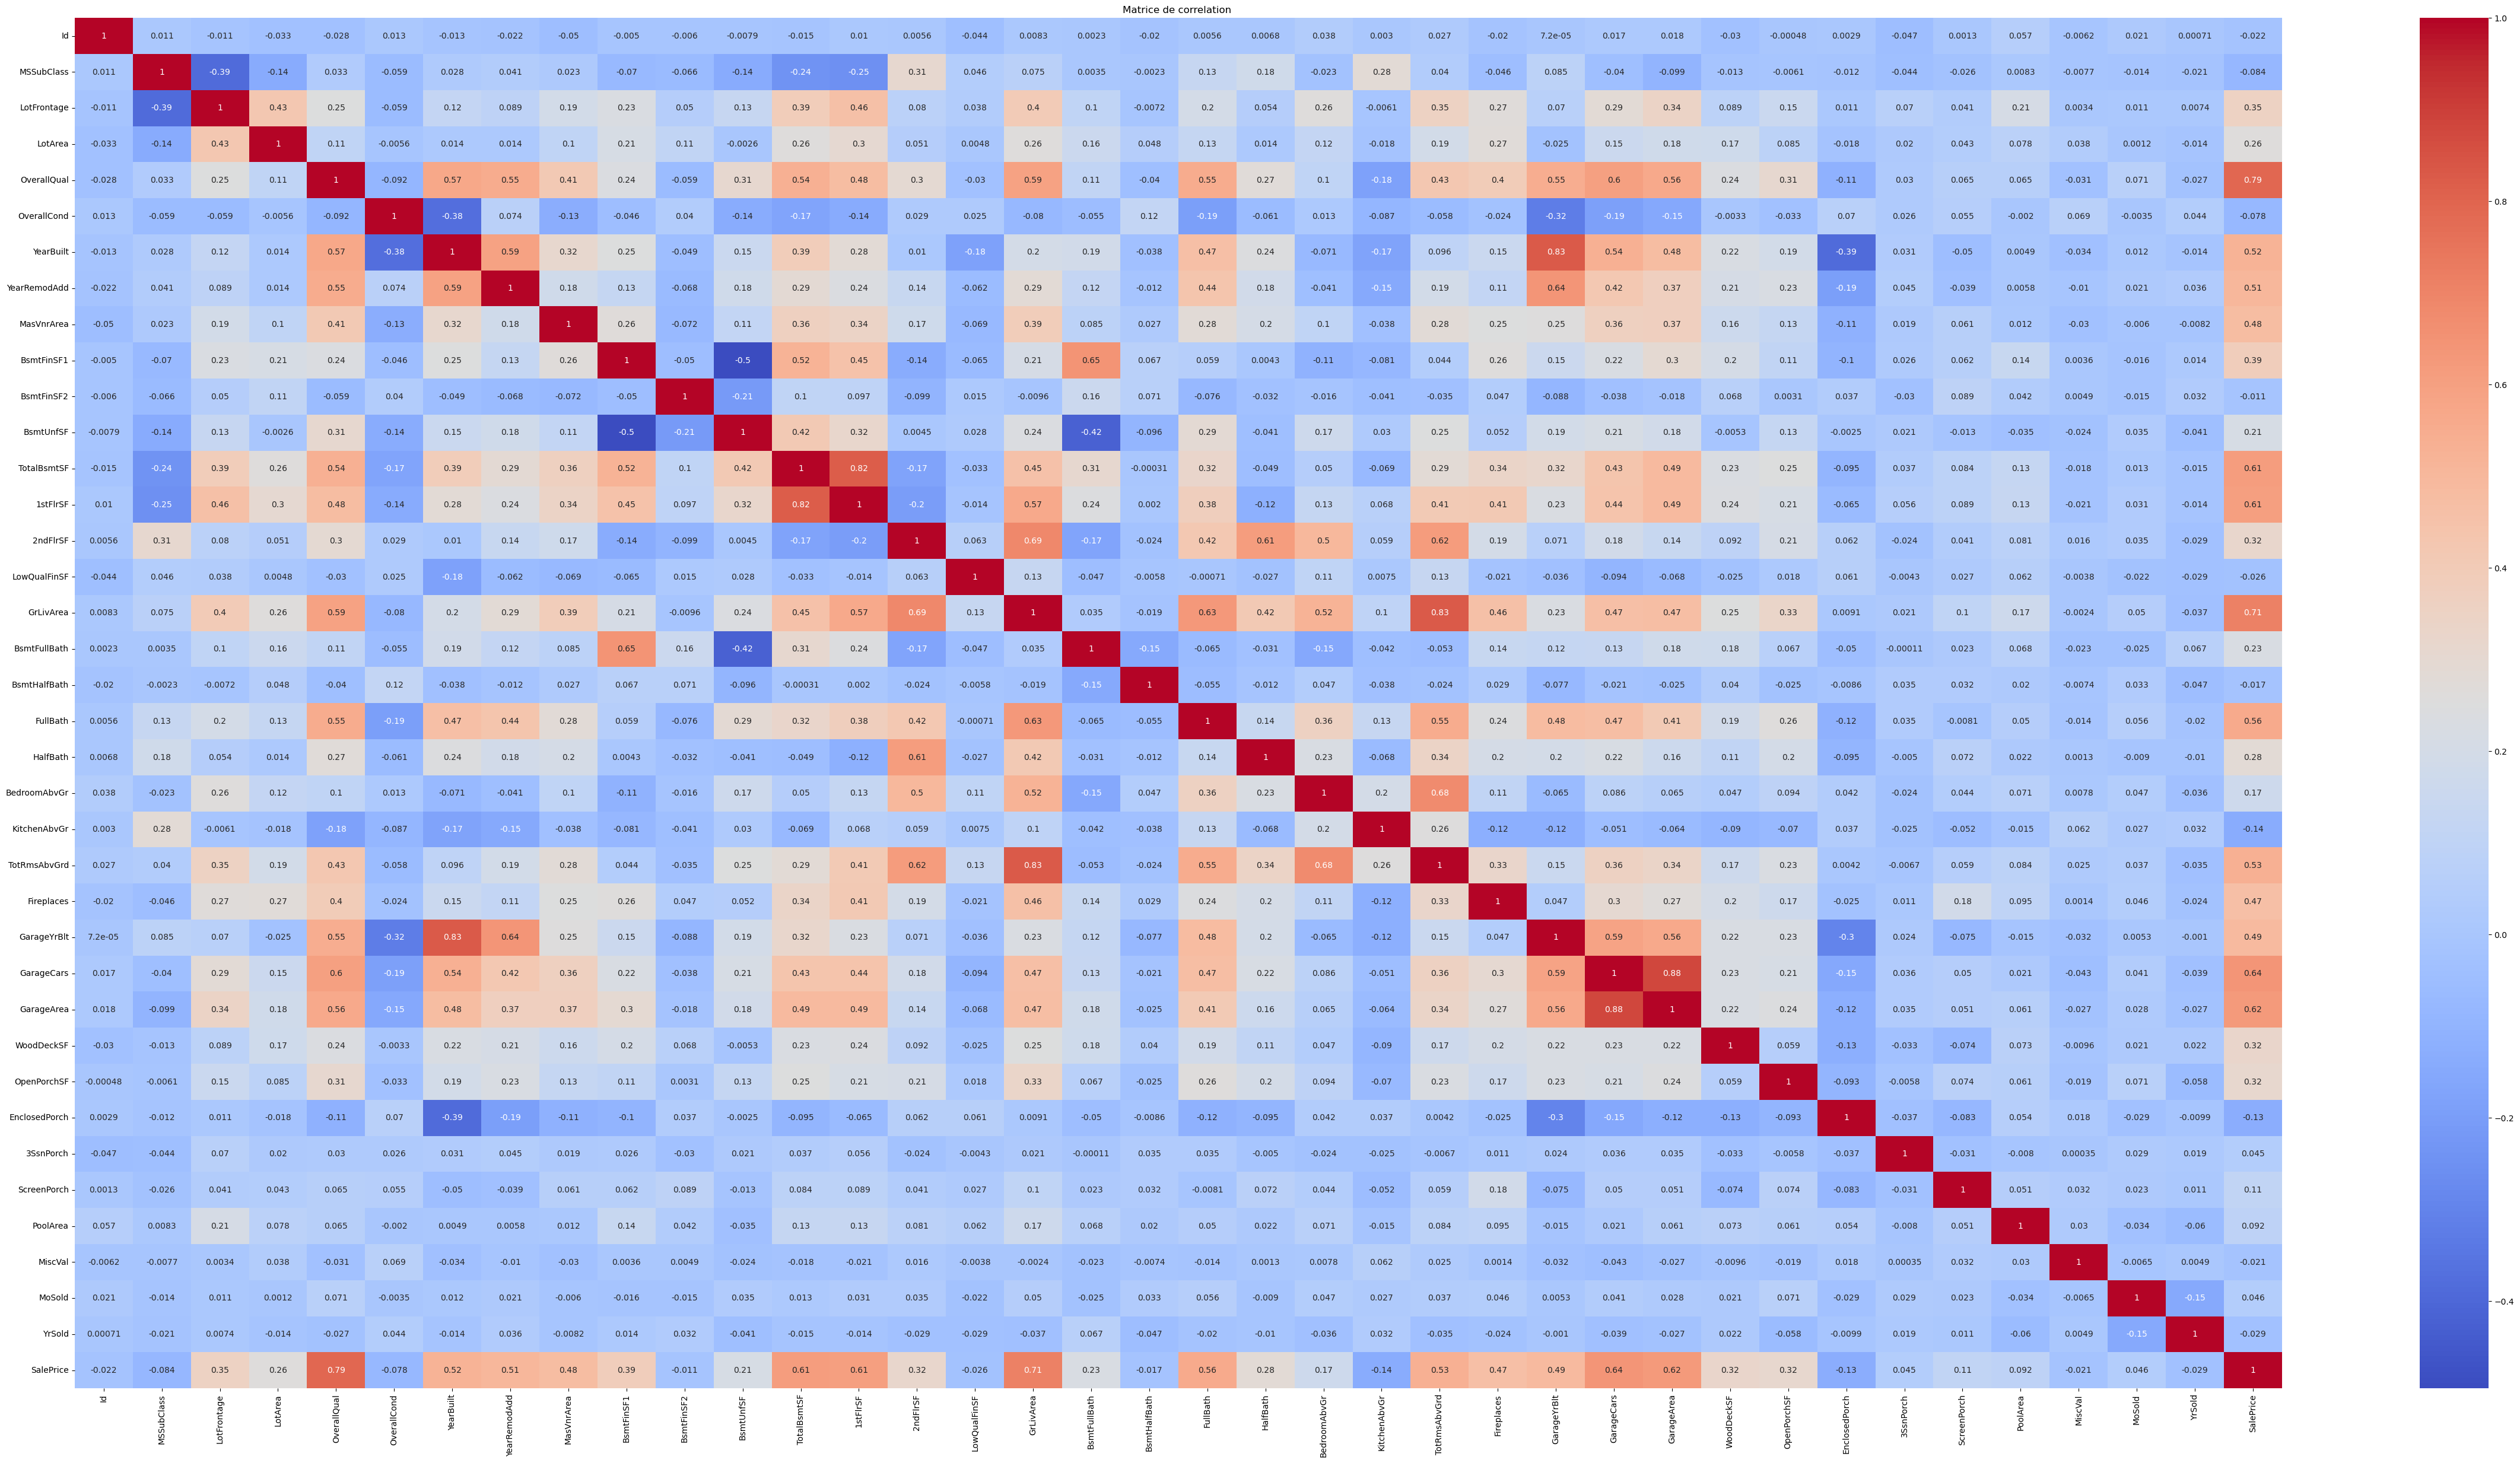

In [214]:
## matrice de correlation 
numeric_cols=data_train.select_dtypes(include=["int64",'float64']).columns[:len(data_train)]
cor_matrix=data_train[numeric_cols].corr()
plt.figure(figsize=(60,30))
ax=sns.heatmap(cor_matrix,annot=True,cmap="coolwarm")
ax.set_title("Matrice de correlation ")
plt.show()

On constate que le prix de ventes des maisons est fortement corrélée avec la qualité globales des materiaux et des finitions et avec la surfaces habitables hors sol ,respectivement (79%, 71% ) et moyennement correlé avec d'autres variables . notons aussi que certaines variables explicativess sont correlé entre eux . 

- II-4-) visualisation des valeurs manquantes 

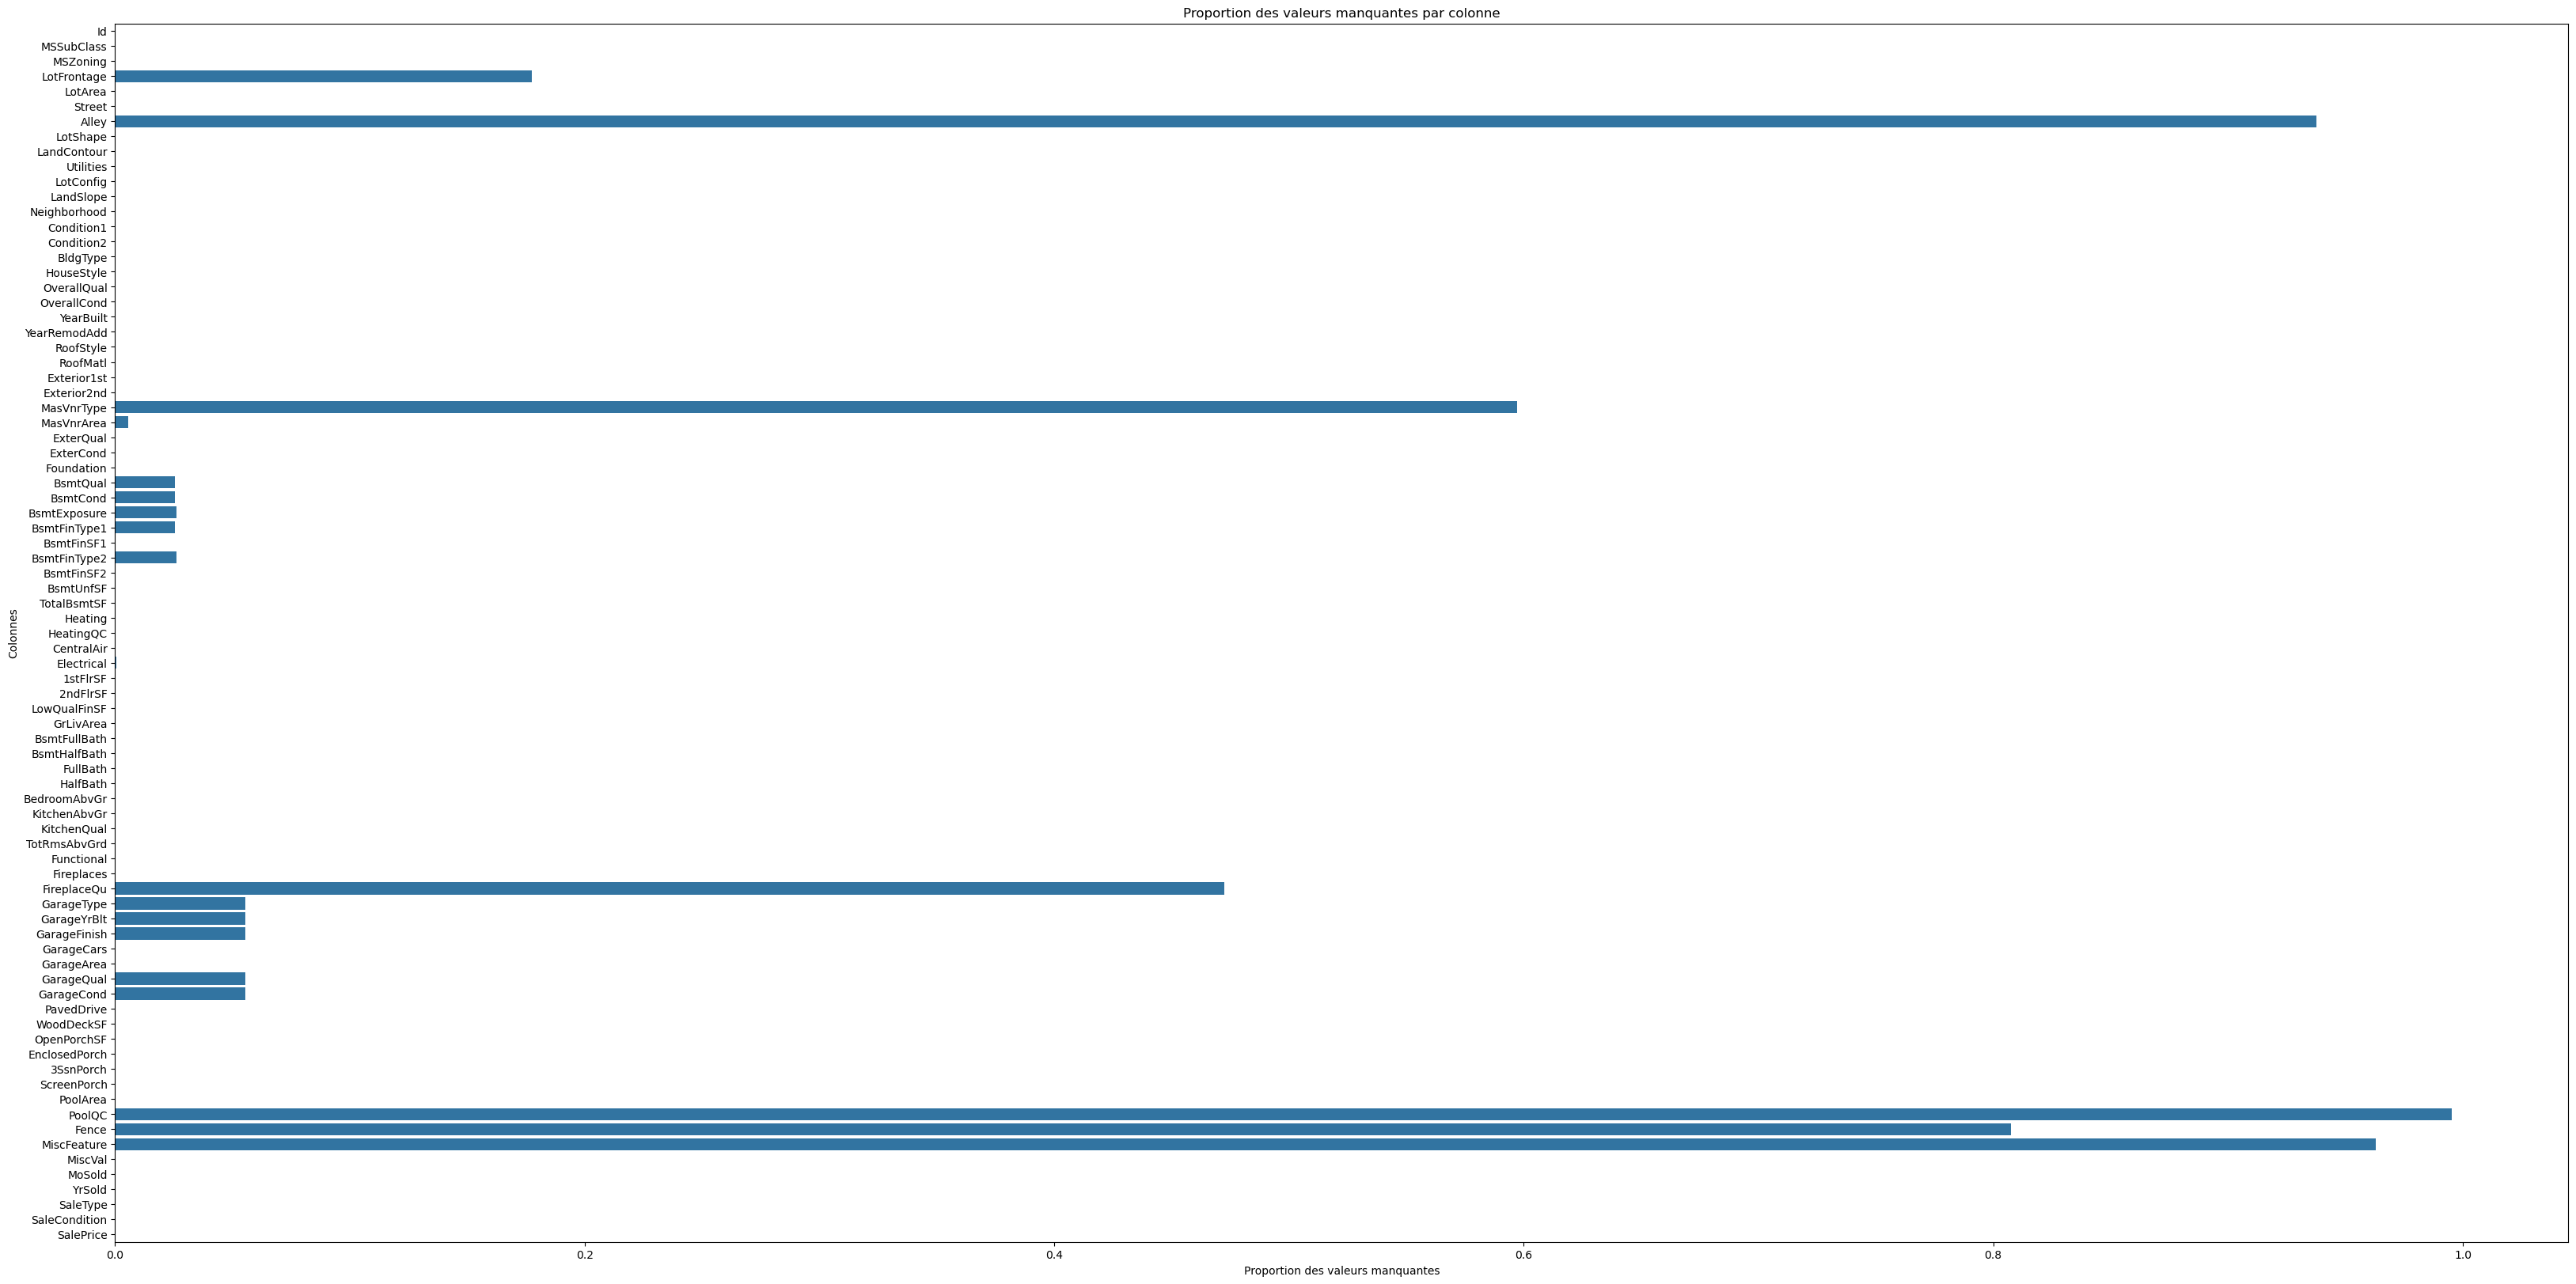

In [215]:
## visualisation des valeurs manquantes 
plt.figure(figsize=(40,20))
sns.barplot(x=data_train.isnull().sum()/data_train.shape[0],y=data_train.columns)
plt.title("Proportion des valeurs manquantes par colonne")
plt.xlabel("Proportion des valeurs manquantes")
plt.ylabel("Colonnes")
plt.show()


In [216]:
#print(f"{(data_train.isnull().sum()/data_train.shape[0])*100 }")
colonnes=[]
pourcentage=[]
for col in data_train.columns[data_train.isnull().any()]:
    colonnes.append(col)
    pourcentage.append((data_train[col].isnull().sum()/data_train.shape[0])*100)
data=[colonnes,pourcentage]
tableau=pd.DataFrame(data,index=["Colonnes","Pourcentage des valeurs manquantes"]).T
print(tableau)


        Colonnes Pourcentage des valeurs manquantes
0    LotFrontage                          17.739726
1          Alley                          93.767123
2     MasVnrType                          59.726027
3     MasVnrArea                           0.547945
4       BsmtQual                           2.534247
5       BsmtCond                           2.534247
6   BsmtExposure                            2.60274
7   BsmtFinType1                           2.534247
8   BsmtFinType2                            2.60274
9     Electrical                           0.068493
10   FireplaceQu                          47.260274
11    GarageType                           5.547945
12   GarageYrBlt                           5.547945
13  GarageFinish                           5.547945
14    GarageQual                           5.547945
15    GarageCond                           5.547945
16        PoolQC                          99.520548
17         Fence                          80.753425
18   MiscFea

In [217]:
inf_val=[]
for i in tableau.index:
    if tableau["Pourcentage des valeurs manquantes"][i]<5:
        inf_val.append(tableau["Colonnes"][i])
print("les colonnes ayant moins de 5% de valeurs manquantes sont :")
print(inf_val)
sup_val=[]
for i in tableau.index: 
    if tableau["Pourcentage des valeurs manquantes"][i]>5 and tableau["Pourcentage des valeurs manquantes"][i]<50:
        sup_val.append(tableau["Colonnes"][i])  
print("="*150)
print("les colonnes ayant entre 5% et 50% de valeurs manquantes sont :")
print(sup_val)
ext_val=[]
for i in tableau.index:
    if tableau["Pourcentage des valeurs manquantes"][i]>50:
        ext_val.append(tableau["Colonnes"][i])
print("="*150)
print("les colonnes ayant plus de 50% de valeurs manquantes sont :")
print(ext_val)

les colonnes ayant moins de 5% de valeurs manquantes sont :
['MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical']
les colonnes ayant entre 5% et 50% de valeurs manquantes sont :
['LotFrontage', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
les colonnes ayant plus de 50% de valeurs manquantes sont :
['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']


- II-5-) visualisation et detection  de valeurs extremes




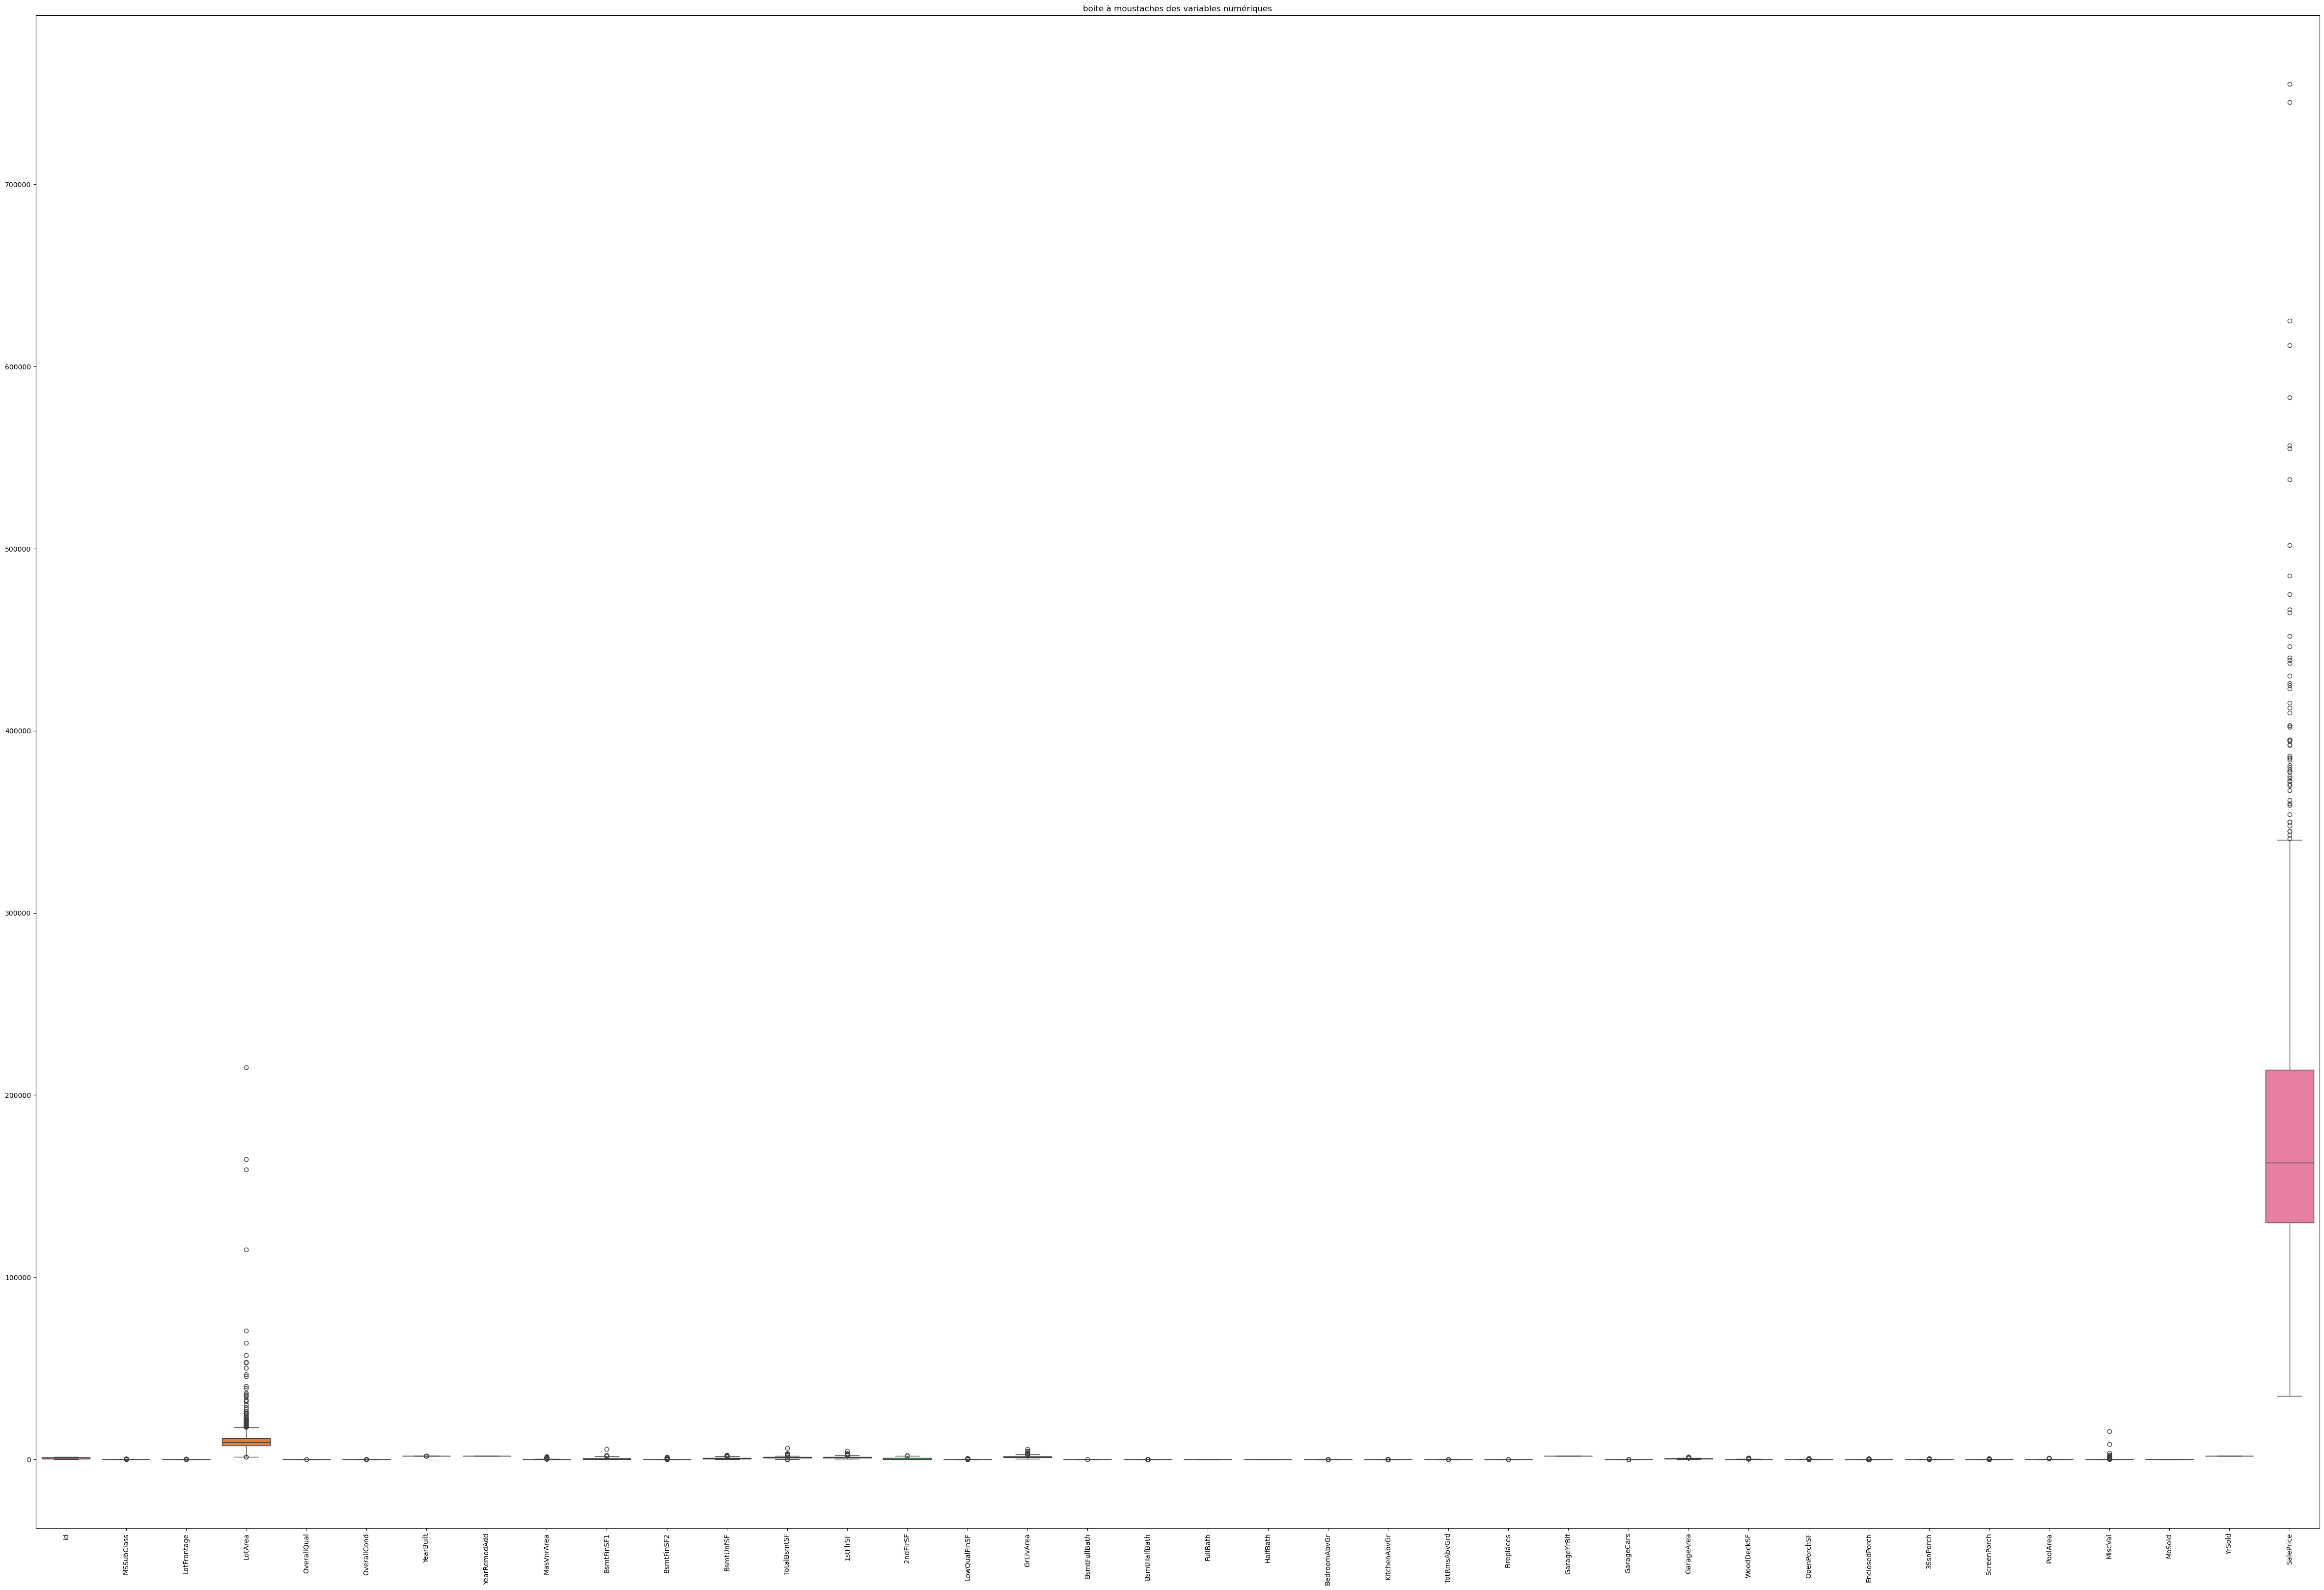

In [218]:
## Visualisation de la distribution des variables
plt.figure(figsize=(60, 40))
sns.boxplot(data_train[numeric_cols])
plt.xticks(rotation=90)
plt.title("boite à moustaches des variables numériques")
plt.show()

On constate qu'a l'exception de 7 variables ( sur 81 ) ,toutes les variables explicatives ont des valeurs extremes . Mais dans le cas de notre études ,ces valeurs extremes sont informatives et elle nous seront utilent dans notre analyse même si elle ne sont representativent. 

- II-6-) Traitement des valeurs manquantes et des valeurs extremes 

In [219]:
## traitement des valeurs manquantes
data_clean=data_train.dropna(subset=["MasVnrArea","BsmtQual","BsmtCond","BsmtExposure", 'BsmtFinType1', 'BsmtFinType2','Electrical'],axis=0)
data_clean.loc[:, "LotFrontage"] = data_clean["LotFrontage"].fillna(data_clean["LotFrontage"].median())


In [220]:
data_clean.loc[:, "GarageYrBlt"] = data_clean["GarageYrBlt"].fillna(0)

In [221]:
data_clean[['Alley',"FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence",'MasVnrType',"MiscFeature"]].fillna("None")
data_clean_mod=data_clean.copy()
data_clean_ana=data_clean.copy()

In [226]:
## Traitement des valeurs extremes 
for col in numeric_cols:
    data_clean_mod.loc[:,f"{col}_log"] = np.log1p(data_clean_mod[col].clip(lower=0))
data_clean_mod.head(5)



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Id_log,MSSubClass_log,LotFrontage_log,LotArea_log,OverallQual_log,OverallCond_log,YearBuilt_log,YearRemodAdd_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageYrBlt_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,MoSold_log,YrSold_log,SalePrice_log
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,0.693147,4.110874,4.189655,9.042040,2.079442,1.791759,7.602900,7.602900,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,1.098612,0.693147,1.386294,0.693147,2.197225,0.000000,7.602900,1.098612,6.308098,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,1.098612,7.605392,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1.098612,3.044522,4.394449,9.169623,1.945910,2.197225,7.589336,7.589336,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,1.098612,0.000000,1.386294,0.693147,1.945910,0.693147,7.589336,1.098612,6.133398,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,1.791759,7.604894,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1.386294,4.110874,4.234107,9.328212,2.079442,1.791759,7.601902,7.602401,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,1.098612,0.693147,1.386294,0.693147,1.945910,0.693147,7.601902,1.098612,6.411818,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,2.302585,7.605392,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1.609438,4.262680,4.110874,9.164401,2.079442,1.791759,7.557995,7.586296,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,0.693147,0.000000,1.386294,0.693147,2.079442,0.693147,7.600402,1.386294,6.466145,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,1.098612,7.604396,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl

In [223]:
data_clean_ana.head()
print(data_clean_ana.shape)

(1412, 81)


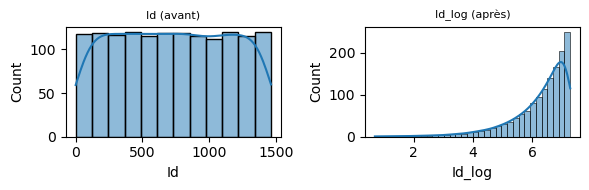

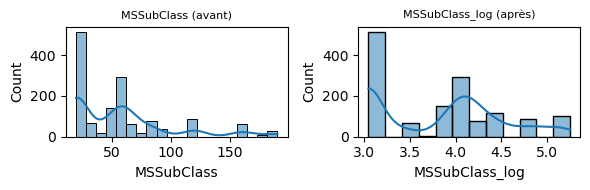

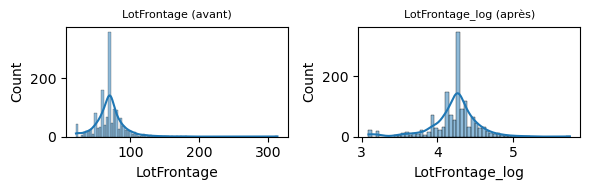

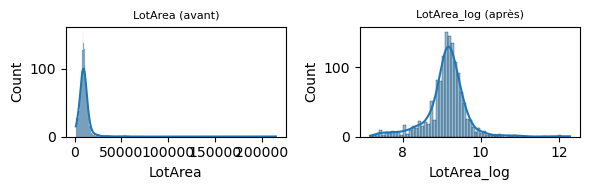

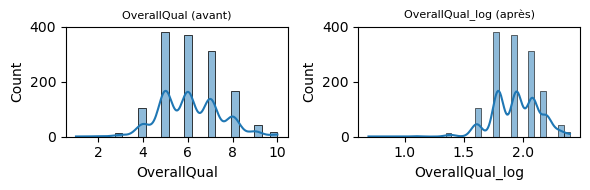

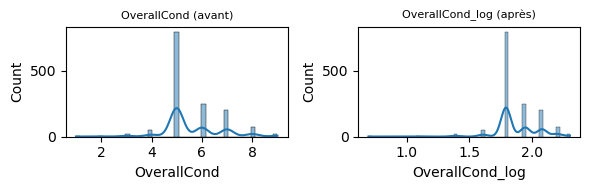

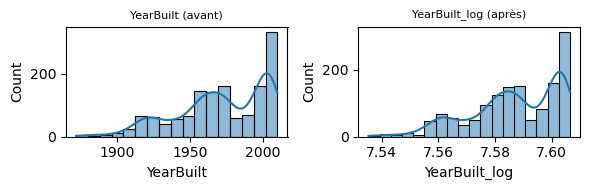

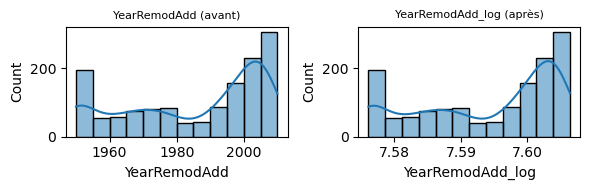

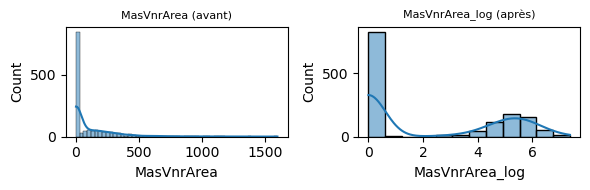

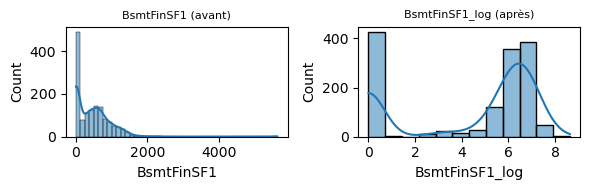

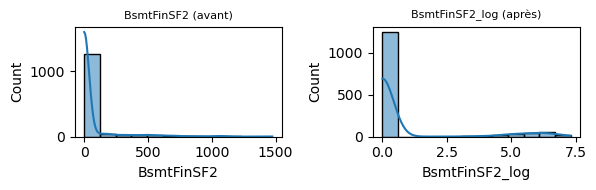

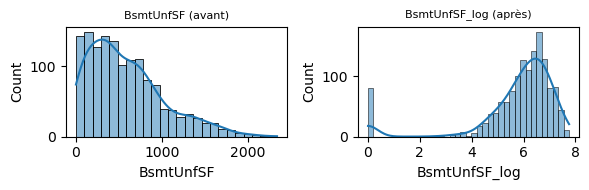

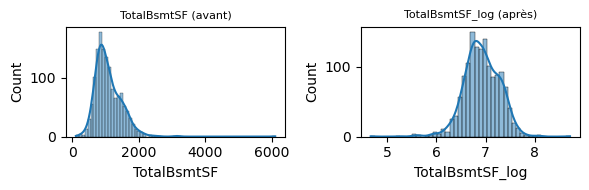

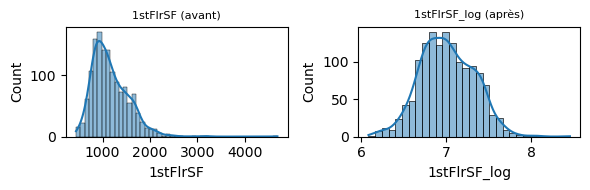

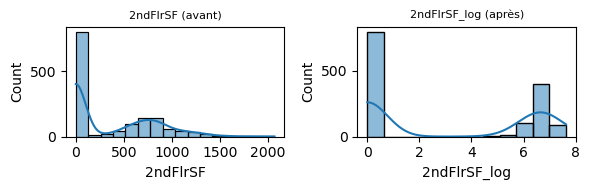

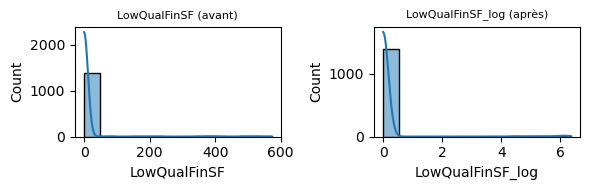

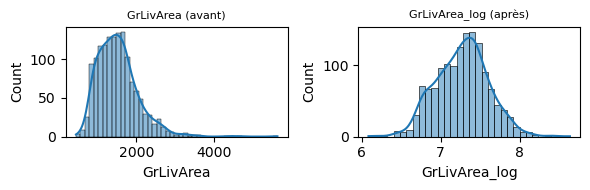

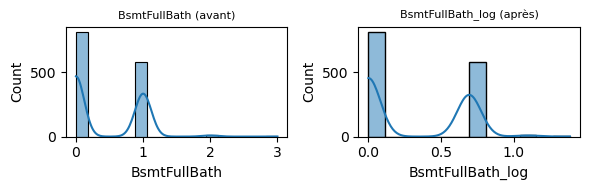

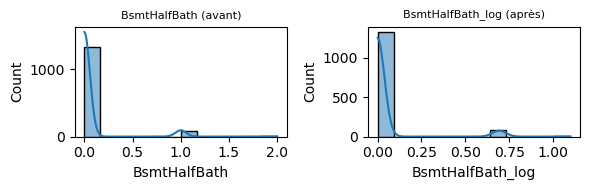

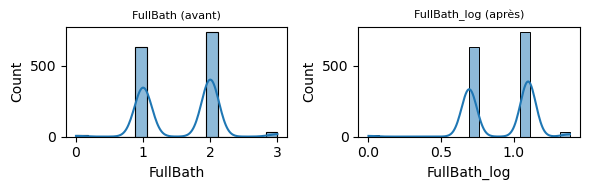

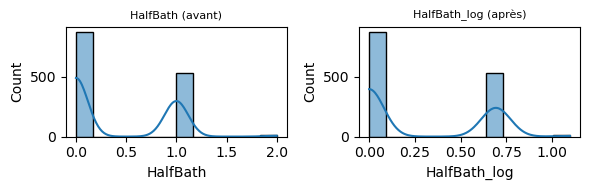

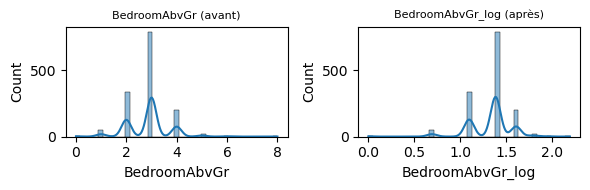

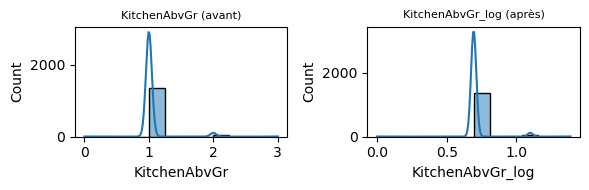

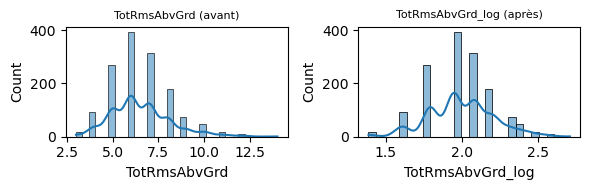

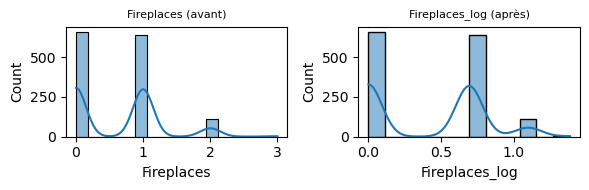

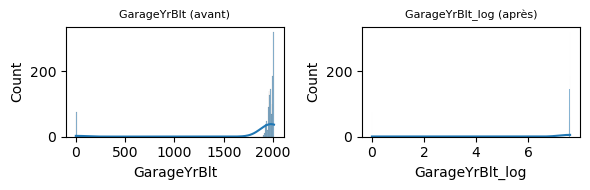

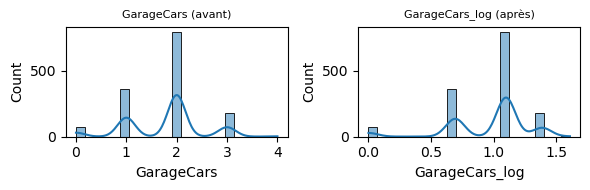

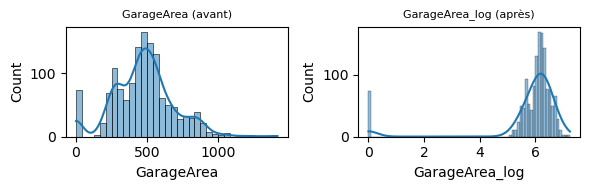

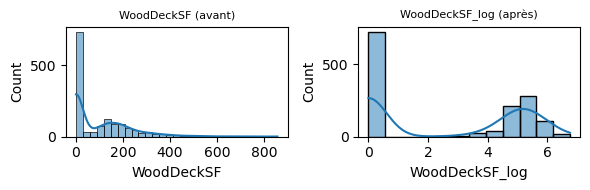

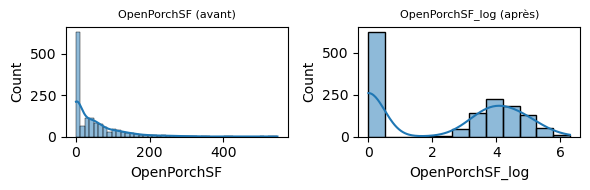

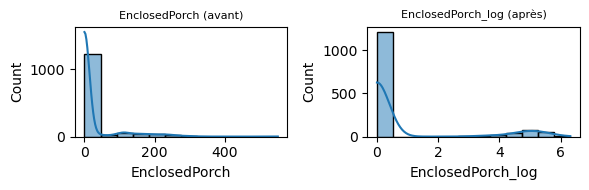

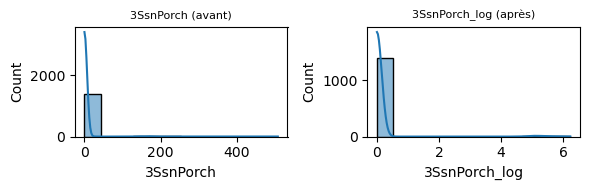

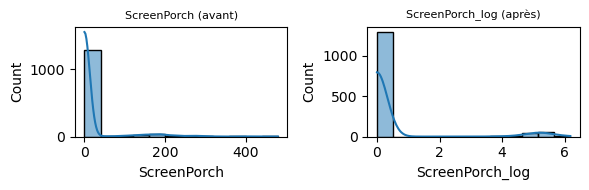

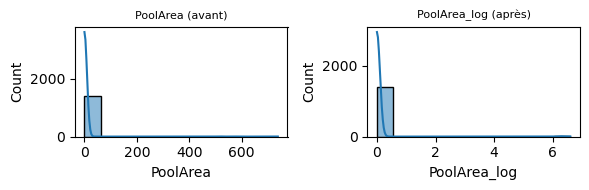

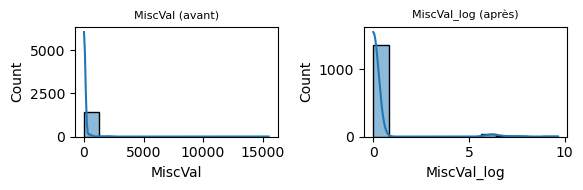

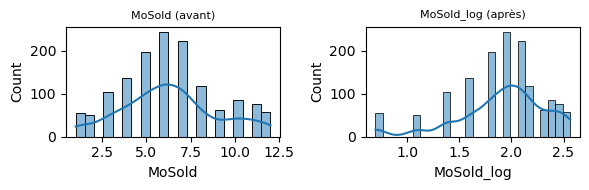

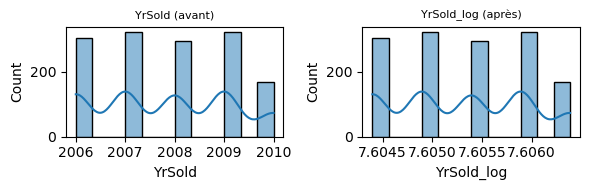

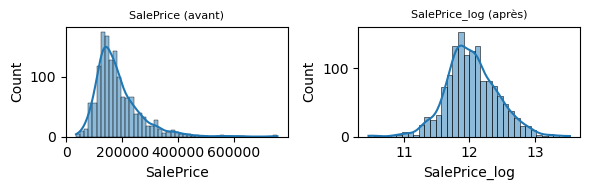

In [224]:
# ...existing code...

for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(6, 2))
    sns.histplot(data_clean_mod[col], kde=True, ax=axes[0])
    axes[0].set_title(f"{col} (avant)", fontsize=8)
    sns.histplot(data_clean_mod[f"{col}_log"], kde=True, ax=axes[1])
    axes[1].set_title(f"{col}_log (après)", fontsize=8)
    plt.tight_layout()
    plt.show()

# ...existing code...

In [225]:
## encodage des variables catégorielles
cat_cols = data_clean.select_dtypes(include=["object"]).columns
data_clean = pd.get_dummies(data_clean, columns=cat_cols, drop_first=True).astype(int)


A faire pour demain : 
- gerer les valeurs manquantes en tenant compte de la nature de valeurs manquantes et de correlations entre les variables 
- gerer les valeurs extreme ,si necessaire 
- voir la distribution des variables (pour voir si unentransformation logarithienne n'est pas necessaire )
- efffectuer une normalsation des données 
- encoder les variables categorielles 
- faire ,si je n'ai rien oublier dans le preposescing,mes analyses 